In [9]:
import pandas as pd
import numpy as np
import pyphen #for syllables
from textblob import TextBlob # for subjectivity 

import matplotlib.pyplot as plt

# Get word2vec from a corpus
from gensim.models import Word2Vec
from nltk.corpus import wordnet
from nltk.util import ngrams


import nltk as nltk
from nltk import ne_chunk, pos_tag, word_tokenize

from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import RegexpTokenizer
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge,LinearRegression,BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [10]:
def read_file(file_name):
    df_file = pd.read_table(file_name, header = None, index_col=2,encoding = "ISO-8859-1")
    df_file.columns = ['Score','other_scores','text']
    df_file = df_file.drop('other_scores', axis = 'columns')
    df_file['text'] = df_file['text'].astype('str')
    return df_file

df_email = read_file('email')
df_news = read_file('news')
df_news['len'] = df_news.text.apply(len)
df_news = df_news[df_news['len'] < 500]
df_news = df_news.drop('len', axis = 'columns')


df_blog = read_file('blog')
df_answers = read_file('answers')

def create_words(temp):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [tokenizer.tokenize(i) for i in temp.values.tolist()]
    flat = [item.lower() for sublist in tokens for item in sublist]
    return flat
def create_word2vec(words):
    vecs = Word2Vec(words)
    return vecs

## CREATING FEATURES

In [11]:
# case
## Number of entirely capitalized words
def entirely_capitalized_num_of_words(temp):
    return sum([1 if i.isupper() == True else 0 for i in temp.split(' ')])

## binary indicator whether a sentence is entirely capitalized
def entirely_capitalized_sentence(temp):
    if entirely_capitalized_num_of_words == len([i for i in temp.split()]):
        return 1
    else:
        return 0

## binary indicator whether the first word is capitalized
def first_word_capitalized(temp):
    if temp[0].isupper():
        return 1
    else:
        return 0

In [12]:
# Dependency (still outstanding!)

In [13]:
# Entity
## One-hot features for entity types (e.g. PERSON, LOCATION) occurring in the sentence
def count_nes(temp):
    tokens = word_tokenize(temp)
    tags = pos_tag(tokens)
    chunked = ne_chunk(tags)
    named_entities = ['DATE','FACILITY','GPE', 'LOCATION', 'MONEY', 'ORGANIZATION','PERCENT','PERSON','TIME']
    counts ={}
    for ne in named_entities:
        counts[ne] = 0
    for tree in chunked.subtrees():
        for named_entity in named_entities:
            if tree.label() == named_entity:
                counts[named_entity] = counts[named_entity] + 1
    return counts
## average length, in characters, of PERSON mentions
def aver_length_person(temp):
    tokens = word_tokenize(temp)
    tags = pos_tag(tokens)
    chunked = ne_chunk(tags)
    word = ''
    for tree in chunked.subtrees():
        if tree.label() == 'PERSON':
            for i in range(len(tree)):
                word = word + tree[i][0]
    return len(word)

In [14]:
# Lexical
## Number of contractions in the sentence, normalized by length
def contractions_norm(temp):
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
    }
    count = 0
    tokens = [i for i in temp.split()]
    tokens = [i.lower() for i in tokens]
    for word in tokens:
        if word in contractions.keys():
            count = count + 1
    return count / len(tokens)

## average word length
def aver_word_length(temp):
    tokens = word_tokenize(temp)
    lengths = []
    for word in tokens:
        lengths.append(len(word))
    return sum(lengths) / len(lengths)

## average word log-frequency according to Google Ngram corpus (used brown corpus and train set wordsinstead)
def aver_log_freq(temp,frequencies):
    freqlist = []
    tokens = [i.lower() for i in word_tokenize(temp)]
    for word in tokens:
        freqlist.append(np.log1p(frequencies[word]))
    return sum(freqlist) / len(freqlist)

## Formality score (to come from Pavlich)

In [15]:
# ngrams
def word_grams(temp, min=1, max=4):
    temp = temp.lower()
    temp = temp.split(' ')
    s = []
    for n in range(min, max):
        for ngram in ngrams(temp, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [16]:
# POS
## Number of occurrences of each POS tag, normalized by the sentence length.

from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')

def postag_occurences(temp):
    counts = {}
    tokens = word_tokenize(temp)
    length = len(tokens)
    pos_tagged = nltk.pos_tag(tokens)
    freq = FreqDist([y for (x,y) in pos_tagged])
    elements = [i for i in freq.elements()]
    for key in tagdict.keys():
        counts[key] = 0
        for element in elements:
            counts[element] = freq[element] / length
    return counts

In [17]:
# punctuation
## Number of ‘?’, ‘...’, and ‘!’ in the sentence
def count_punct(temp):
    tokens = word_tokenize(temp)
    counts = {}
    counts['...'] = 0
    counts['!'] = 0
    counts['?'] = 0
    for token in tokens:
        if token in counts.keys():
            counts[token] = counts[token] + 1
    return counts

In [18]:
# readability
## Length of the sentence, in words and characters; Flesch-Kincaid Grade Level score
def num_of_words(temp):
    tokens = word_tokenize(temp)
    return len(tokens)
def num_of_chars(temp):
    return(len(temp))

def count_syllables(temp):
    dic = pyphen.Pyphen(lang ='en')
    return (len(dic.inserted(temp).split('-')))

def kinclaid_score(temp):
    tokenizer = RegexpTokenizer(r'\w+')
    total_words = len(tokenizer.tokenize(temp))
    total_sentence = 1
    total_syllables = sum([count_syllables(word) for word in tokenizer.tokenize(temp)])
    count_syllables(temp)

    score = 0.39 * ((total_words / total_sentence)) + 11.8*((total_syllables / total_words)) - 15.59
    return score

In [19]:
# Subjectivity (all normalized by sentence length)
## Number of passive constructions (outstanding)

## number of hedge words (fillers added)
def count_hedge_words(temp):
    hedge_words = pd.read_table('hedge_words.txt',header = None)
    hedge_words = hedge_words[0].values.tolist()
    words = word_tokenize(temp)
    counts = 0
    for word in words:
        if word.lower() in hedge_words:
            counts = counts + 1
    return counts

def count_filler_words(temp):
    hedge_words = pd.read_table('filler_words.txt',header = None)
    hedge_words = hedge_words[0].values.tolist()
    words = word_tokenize(temp)
    counts = 0
    for word in words:
        if word.lower() in hedge_words:
            counts = counts + 1
    return counts

## number of 1st person pronouns
def num_of_firstperson(temp):
    list_of_pronouns = ['i','me','mine','my','we','us','our','ours']
    words = word_tokenize(temp)
    words = [word.lower() for word in words]
    counts = 0
    for word in words:
        if word in list_of_pronouns:
            counts = counts + 1
    return counts

## number of 3rd person pronouns
def num_of_thirdperson(temp):
    list_of_pronouns = ['he','she','it','him','her','its', 'hers', 'they','them','their','theirs']
    words = word_tokenize(temp)
    words = [word.lower() for word in words]
    counts = 0
    for word in words:
        if word in list_of_pronouns:
            counts = counts + 1
    return counts

## subjectivity according to the TextBlob sentiment module
def subjectivity(temp):
    return TextBlob(temp).sentiment.subjectivity
## binary indicator for whether the sentiment is positive or negative, according to the TextBlob sentiment module
def sentiment(temp):
    if TextBlob(temp).sentiment.polarity >= 0:
        return 1
    else:
        return 0

In [20]:
# word2vec
## Average of word vectors using pre-trained word2vec embeddings, skipping OOV words.
# Get word2vec from a corpus
other_sents = df_news.text.apply(str.lower)
# sents = [[i] for i in sents]
all_sents = [word_tokenize(i) for i in other_sents]

brown_sentslower = [[word.lower() for word in element]
                    for element in brown.sents()]

all_sents = brown_sentslower + all_sents

vec_model = create_word2vec(all_sents)

In [21]:
def wordvector(temp):
    temp = temp.lower()
    temp = word_tokenize(temp)
    vecs = np.zeros((100,))
    for word in temp:
        if word in vec_model.wv:
            vecs = vecs + vec_model[word]
        else:
            vecs = vecs + np.empty((100,))
    return vecs / len(temp)

## CREATE DATAFRAME FOR FITTING

In [22]:
# Lexical analysis (create frequencies)
lowered = df_news.text.apply(str.lower)

all_words_1 = ''
for i in lowered.values.tolist():
    all_words_1 = all_words_1 + i

frequencies = FreqDist(all_words_1.split())


In [23]:
new_df = df_news.text.apply(wordvector)

# Prepare data
series = pd.Series(new_df.values)

temp = pd.DataFrame(series.values.tolist(),index=df_news.index)

from sklearn.preprocessing import robust_scale,RobustScaler
scaler = RobustScaler(quantile_range=(49.0,51.0))

scaler = scaler.fit(temp)

In [24]:
def transformation(temp):
    transformed = []
    transformed.extend([(entirely_capitalized_num_of_words(temp))])
    transformed.extend([(entirely_capitalized_sentence(temp))])
    transformed.extend([(first_word_capitalized(temp))])
    transformed.extend(list(count_nes(temp).values()))
    transformed.extend([contractions_norm(temp)])
    transformed.extend([aver_word_length(temp)])
    transformed.extend([aver_log_freq(temp.lower(), frequencies)])
    transformed.extend(list(postag_occurences(temp).values()))
    transformed.extend(list(count_punct(temp).values()))
    transformed.extend([num_of_words(temp)])
    transformed.extend([num_of_chars(temp)])
    transformed.extend([count_syllables(temp)])
    transformed.extend([kinclaid_score(temp)])
    transformed.extend([count_hedge_words(temp)])
    transformed.extend([count_filler_words(temp)])
    transformed.extend([num_of_firstperson(temp)])
    transformed.extend([num_of_thirdperson(temp)])
    transformed.extend([subjectivity(temp)])
    transformed.extend([sentiment(temp)])
    transformed.extend([item for sublist in scaler.transform(np.reshape(wordvector(temp),(1,100))).tolist() for item in sublist])
    return np.array(transformed)

In [25]:
X = df_news.text.apply(transformation)

X= np.array(list(X.values))

y = df_news.Score

In [26]:
# Grid search for parameters
alphas = [10**(i) for i in range(5)]

grid_scores = {}
for alpha in alphas:
    clf = Ridge(alpha = alpha)
    score = np.mean(cross_val_score(clf,X,y,scoring='r2',cv = 20))
    grid_scores[str(alpha)] = score

In [27]:
grid_scores

{'1': -0.23046058609467698,
 '10': -0.17545413682623473,
 '100': -0.287626780878671,
 '1000': -0.8792559520988419,
 '10000': -1.3206618248535786}

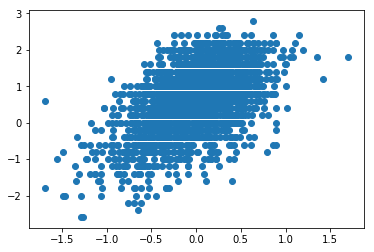

In [28]:
clf = Ridge(normalize=True,alpha = 1)
clf.fit(X,y);
preds = clf.predict(X)
preds = ((preds - np.mean(y)) / (np.std(y)))
plt.scatter(preds, y)

In [29]:
def get_model_score(temp,clf):
    temp = transformation(temp)
    temp = np.reshape(temp,(1,173))
    pred = clf.predict(temp)
    p_mean = np.mean(clf.predict(X))
    p_std = np.std(clf.predict(X))
    p_z = (pred - p_mean) / p_std
    p_final = (p_z) * np.std(y) + np.mean(y)
    return p_final

In [32]:
# Change test word and test the model.
test = 'I can not say that this is acceptable.'

get_model_score(test,clf)

array([-0.57262581])

In [31]:
# save the model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))